In [0]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

In [0]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [0]:
iv3=InceptionV3()

In [0]:
print(iv3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
#Importar imagenes
from keras.preprocessing import image

x=image.load_img("./cat.jpeg")
print(x)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x331 at 0x7F3F5ACB6BA8>


In [0]:
x=image.img_to_array(x)

In [0]:
print(x.shape) #Muestra altura, profundidad y color

(331, 500, 3)


In [0]:
#Cambiar el tamaño de la imagen

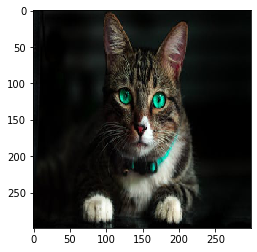

In [47]:
x=image.load_img("./cat.jpeg", target_size=(299,299))
x=image.img_to_array(x)
plt.imshow(x.astype(np.uint8))
plt.show()

In [0]:
#Modelo IA maneja un rango desde -1 y 1, normalizar de la siguiente forma
#Cambio  de rango 0,255=>-1,1
x/=255
x-=0.5
x*=2
print(x)

In [0]:
#Añaddir una dimension para cumplir requerimientos modelo IA
x=x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])

print(x.shape)

(1, 299, 299, 3)


In [0]:
y=iv3.predict(x)

In [0]:
y.shape

(1, 1000)

In [0]:
#Para cada una de las clases se obtiene una probabilidad
#Un vector con 1000 probabilidades

#Buscar un maximo entre los vectores
#**Keras decode_predictions mapea las probabilidades con el nombre de la clases y ordenadas**

In [0]:
decode_predictions(y)

40960/35363 [==================================] - 0s 0us/step


[[('n02123045', 'tabby', 0.9220212),
  ('n02123159', 'tiger_cat', 0.04098036),
  ('n02124075', 'Egyptian_cat', 0.010916955),
  ('n04074963', 'remote_control', 0.00034941317),
  ('n02123394', 'Persian_cat', 0.0002809667)]]

# **Ataques adversarios** (Romper el modelo) 

In [0]:
inp_layer=iv3.layers[0].input
out_layer=iv3.layers[-1].output

print(inp_layer)
print(out_layer)

Tensor("input_1:0", shape=(?, 299, 299, 3), dtype=float32)
Tensor("predictions/Softmax:0", shape=(?, 1000), dtype=float32)


In [37]:
target_class=951 #Clase a la que queremos que el modelo nos muestre engañado e modelo

loss=out_layer[0, target_class]

grad=K.gradients(loss, inp_layer)[0]

optimize_gradient=K.function([inp_layer, K.learning_phase()], [grad, loss])
adv=np.copy(x)

#Que tanto el modelo de optimizacion puede cambiar la imagen para que no
#Sea perceptible por el ojo humano: 
pert=0.01
max_pert=x+0.01
min_pert=x-0.01

cost=0.0
while cost<0.95:
  gr, cost=optimize_gradient([adv, 0])
  adv+=gr
  adv=np.clip(adv, min_pert, max_pert) #Los valores no pueden ser mayor o menor a
  adv=np.clip(adv,-1,1)
  print('Target coast: {}'.format(cost))


Target coast: 8.932321179599967e-06
Target coast: 8.943140528572258e-06
Target coast: 8.954024451668374e-06
Target coast: 8.965032066043932e-06
Target coast: 8.976099707069807e-06
Target coast: 8.987242836155929e-06
Target coast: 8.998453267849982e-06
Target coast: 9.009646419144701e-06
Target coast: 9.020998732012231e-06
Target coast: 9.032339221448638e-06
Target coast: 9.043669706443325e-06
Target coast: 9.055073860508855e-06
Target coast: 9.066441634786315e-06
Target coast: 9.077834874915425e-06
Target coast: 9.089344530366361e-06
Target coast: 9.100787792704068e-06
Target coast: 9.11237748368876e-06
Target coast: 9.123944437305909e-06
Target coast: 9.13557960302569e-06
Target coast: 9.147190212388523e-06
Target coast: 9.158835382550023e-06
Target coast: 9.170424164040014e-06
Target coast: 9.182027497445233e-06
Target coast: 9.193558980769012e-06
Target coast: 9.205032256431878e-06
Target coast: 9.216639227815904e-06
Target coast: 9.228188901033718e-06
Target coast: 9.23970310395816

In [0]:
adv/=2
adv+=0.5
adv*=255

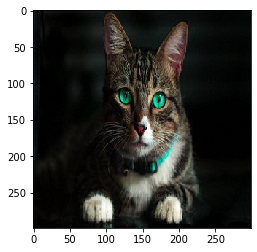

In [40]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [0]:
from PIL import Image
im=Image.fromarray(adv[0].astype(np.uint8))
im.save("./hacked.png")

In [42]:
#Probar imagen modificada
x=image.load_img("./hacked.png", target_size=(299,299))
x=image.img_to_array(x)
print(x.shape)
x/=255
x-=0.5
x*=2

x=x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])
y=iv3.predict(x)
decode_predictions(y)

(299, 299, 3)


[[('n07749582', 'lemon', 0.998319),
  ('n07747607', 'orange', 0.0012861558),
  ('n04409515', 'tennis_ball', 7.167576e-05),
  ('n09229709', 'bubble', 4.1929325e-05),
  ('n04509417', 'unicycle', 3.1016592e-05)]]

Formato png no degrada el ataque ya que si se comprime la imagen las pequeñas variaciones pueden ser eliminadas